# Benchmark against other methods


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import json
import seaborn as sns
import matplotlib.transforms as mtransforms
from bread import vis
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bread.algo import tracking
from bread.data import *
from sklearn.metrics import confusion_matrix
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
from glob import glob
import sys
import os.path
sys.path.append('../../src/libraries')  # import YeaZ

## Load testing data


In [3]:
seg = SegmentationFile.from_h5(
    '../../data/colony000_corrected/segmentation_colony000_corrected.h5').get_segmentation("FOV0")
microscopy = Microscopy.from_tiff(
    '../../data/microscopies/colony000_microscopy.tif')
feat = Features(seg, nn_threshold=12, scale_length=1, scale_time=1)

# on average, first frame cells have an area of 2078.0 in the train set
mean_cell_area = 2078.0
area_list = []
cells_first_frame = seg.cell_ids(0)
for cell in cells_first_frame:
    area_list.append(feat.cell_area(0, cell))
scale = np.sqrt(mean_cell_area / np.mean(area_list))
print(scale)
# replace features with correct scale
feat = Features(seg, nn_threshold=12, scale_length=scale, scale_time=1)

1.3686222125054746


In [5]:
microscopy.get_frame('FOV0', 0).shape

(1290, 1377)

In [7]:
print(feat.cell_area(0, 1))
print(feat.cell_area(0, 2))
print(feat.cell_area(0, 3))

1057.3800563380282
2781.59323943662
4237.949295774648


In [8]:
max_dt = 4
interframes = [(idt, idt+dt) for idt, dt in itertools.product(
    range(146), range(1, max_dt+1)) if idt+dt < 146]
print(f'{len(interframes)} interframe samples')

574 interframe samples


In [9]:
results = {'gcn': {}, 'yeaz': {}, 'tracx': {}}

In [10]:
recompute = True  # notebook flag to force recomputing the accuracies

In [11]:
# directory for results
basedir = Path(
    '../../data-clean/generated/tracking/compare/colony000_corrected')

## Our method (GCN)


In [12]:
modelpath = Path(
    '/Users/farzanehwork/Documents/codes/bread/data-clean/generated/tracking_cellFid1_edgeFid0_dist12/models/2023-07-20 14:06:19')

### Load model from pickle


In [13]:
with open(modelpath / 'pickle.pkl', 'rb') as file:
    net: tracking.AssignmentClassifier = pickle.load(file)

net.trim_for_prediction()
net

<class 'bread.algo.tracking._classifier.AssignmentClassifier'>[initialized](
  module_=GNNTracker(
    (node_encoder): MLP(16, 120, 120, 120, 120)
    (edge_encoder): MLP(10, 120, 120, 120, 120)
    (layers): ModuleList(
      (0-4): 5 x DeepGCNLayer(block=res+)
    )
    (out): MLP(120, 60, 30, 1)
  ),
)

In [16]:
dataset_cell_features = {
    0: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc"],  # default
    # with x and y coordinates
    1: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc", "x", "y"],
    2: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc", "age"],  # with age
    # with x and y coordinates and age
    3: ["area", "r_equiv", "r_maj", "r_min", "angle", "ecc", "x", "y", "age"],
}
dataset_edge_features = {
    0: ["cmtocm_x", "cmtocm_y", "cmtocm_len", "cmtocm_angle", "contour_dist",],  # default
    # with maj angle instead of angle
    1: ["cmtocm_x", "cmtocm_y", "cmtocm_len", "cmtocm_angle", "contour_dist", "majmaj_angle",],
}

In [18]:
ga = tracking.build_assgraph(tracking.build_cellgraph(
    feat, 50, cell_features=dataset_cell_features[1],
    edge_features=dataset_edge_features[0]),
    tracking.build_cellgraph(feat, 55, cell_features=dataset_cell_features[1],
                             edge_features=dataset_edge_features[0]), include_target_feature=True)
gat, *_ = tracking.to_data(ga)
yhat = net.predict_assignment(gat)
print(yhat)
yhat = yhat.flatten()
y = gat.y.squeeze().cpu().numpy()
confusion_matrix(y, yhat.flat)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


array([[418,   0],
       [  0,  19]])

### Load model from params


In [17]:
from bread.algo.tracking import GraphLoader, GNNTracker, InMemoryAssignmentDataset
from skorch.classifier import NeuralNetClassifier
import torch

with open(modelpath / 'hyperparams.json') as file:
    hparams = json.load(file)

# first initialize the model
new_net = NeuralNetClassifier(
    GNNTracker,
    module__num_node_attr=hparams['num_node_attr'],
    module__num_edge_attr=hparams['num_edge_attr'],
    module__dropout_rate=hparams['dropout_rate'],
    module__encoder_hidden_channels=hparams['encoder_hidden_channels'],
    module__encoder_num_layers=hparams['encoder_num_layers'],
    module__conv_hidden_channels=hparams['conv_hidden_channels'],
    module__conv_num_layers=hparams['conv_num_layers'],
    module__num_classes=1,
    iterator_train=GraphLoader,
    iterator_valid=GraphLoader,
    criterion=torch.nn.BCEWithLogitsLoss,
).initialize()
new_net.load_params(modelpath / 'params.pt')

dataset = InMemoryAssignmentDataset([
    tracking.to_data(tracking.build_assgraph(tracking.build_cellgraph(
        feat, 50), tracking.build_cellgraph(feat, 55), include_target_feature=True))[0]
])
# unactivated outputs
print(new_net.forward(dataset[0:1]).reshape(
    (len(dataset[0].cell_ids1), len(dataset[0].cell_ids2))))
# activated outputs
# WARNING : this is just applying a rounding operation, this is not the linear assignment !!
print(new_net.predict(dataset[0:1]).reshape(
    (len(dataset[0].cell_ids1), len(dataset[0].cell_ids2))))

tensor([[ 8.1522, -2.3395, -2.2493, -2.1835, -2.1669, -2.2971, -2.0846, -2.0465,
         -2.1615, -2.0716, -2.2613, -2.1695, -2.7298, -2.1631, -2.3212, -2.7039,
         -2.4159, -2.3674, -2.1661, -2.6114, -2.5863, -2.4779, -2.4885],
        [-2.3641,  2.9820, -2.2103, -2.1942, -2.2252, -2.2954, -1.9763, -2.4661,
         -1.8478, -2.2512, -2.3345, -2.4490, -2.6688, -2.0475, -1.9192, -2.8379,
         -2.2965, -1.8821, -2.1149, -2.6154, -2.9137, -2.4839, -2.1727],
        [-2.2047, -1.9708,  6.0943, -1.8656, -2.2273, -1.9272, -2.2646, -2.2077,
         -2.2880, -2.0033, -2.1914, -2.2412, -2.3093, -1.9670, -2.1713, -2.2882,
         -1.9616, -2.2636, -2.2478, -1.9765, -2.1951, -2.2433, -2.2904],
        [-2.2852, -2.2297, -2.1777,  0.2288, -2.1786, -2.2004, -2.1987, -2.1820,
         -1.9761, -2.2356, -2.2837, -2.2192, -2.7048, -2.1999, -1.9392, -2.5458,
         -2.2489, -2.1128, -2.1186, -2.9007, -2.3615, -3.0061, -1.9150],
        [-2.1026, -2.3104, -2.1533, -1.9757, 13.5389, -2.270

### compute


In [21]:
if recompute:
    results['gcn'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for idt1, idt2 in tqdm(interframes):
        ga = tracking.build_assgraph(
            tracking.build_cellgraph(
                feat,
                idt1,
                cell_features=dataset_cell_features[1],
                edge_features=dataset_edge_features[0]
            ),
            tracking.build_cellgraph(
                feat,
                idt2,
                cell_features=dataset_cell_features[1],
                edge_features=dataset_edge_features[0]),
            include_target_feature=True)
        gat, *_ = tracking.to_data(ga)

        yhat = net.predict_assignment(gat).flatten()
        y = gat.y.squeeze().cpu().numpy()

        results['gcn']['confusion'].append(confusion_matrix(y, yhat))
        results['gcn']['t1'].append(idt1)
        results['gcn']['t2'].append(idt2)

 44%|████▎     | 251/574 [02:53<09:16,  1.72s/it]/Users/farzanehwork/Documents/codes/bread/src/bread/data/_data.py:603: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))
 75%|███████▌  | 431/574 [22:19<38:20, 16.09s/it]/Users/farzanehwork/Documents/codes/bread/src/bread/data/_data.py:603: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))
 85%|████████▍ | 487/574 [45:49<50:23, 34.75s/it]/Users/farzanehwork/Documents/codes/bread/src/bread/data/_data.py:603: MultipleContoursWarning: OpenCV returned multiple contours, 2 found.
  warnings.warn(Contour.MultipleContoursWarning(len(contours_cv)))
100%|██████████| 574/574 [2:34:08<00:00, 16.11s/it] 


## YeaZ


In [19]:
import YeaZ.unet.hungarian as YeaZ_hung

In [20]:
import scipy.spatial.distance


def match_cellids_from_segs(segframe1: np.ndarray, segframe2: np.ndarray, eps=1e-6):
    # Matches cellids between two identical segmentations, which use different numberings
    seg1 = Segmentation(segframe1[None, ...], 'FOV0')
    seg2 = Segmentation(segframe2[None, ...], 'FOV0')
    cms1 = seg1.cms(0)
    cms2 = seg2.cms(0)

    # compare centers of masses
    dists = scipy.spatial.distance.cdist(cms1, cms2)
    matches = dists < eps
    idx1, idx2 = matches.nonzero()
    assert not len(idx2) < len(cms1), 'not all cells were matched'
    assert not len(idx2) > len(cms1), 'too many cells were matched'

    return idx2

In [21]:
if recompute:
    results['yeaz'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for idt1, idt2 in tqdm(interframes):
        seg_hat = YeaZ_hung.correspondence(seg[idt1], seg[idt2])
        idmap2 = match_cellids_from_segs(seg[idt2], seg_hat)

        y = tracking.assignment_from_segmentation(seg, idt1, idt2)
        yhat = tracking.assignment_from_segmentation(seg, idt1, idt2)[
            :, idmap2]

        results['yeaz']['confusion'].append(
            confusion_matrix(y.flatten(), yhat.flatten()))
        results['yeaz']['t1'].append(idt1)
        results['yeaz']['t2'].append(idt2)

100%|██████████| 574/574 [26:38<00:00,  2.78s/it]


## TracX


In [4]:
max_dt = 1

In [22]:
# since tracx works with matlab, we need to export the data to a convenient format
# then run it via matlab
# then analyze the results

import tifffile

fileid2frameid = defaultdict(dict)
dowrite = False

for dt in range(1, max_dt+1):
    maskdir = str(basedir / 'TracX/framediff{:02d}/mask').format(dt)
    microdir = str(basedir / 'TracX/framediff{:02d}/microscopy').format(dt)

    os.makedirs(maskdir, exist_ok=True)
    os.makedirs(microdir, exist_ok=True)

    fileid = 0
    for startframe in tqdm(range(0, dt), desc=f'framediff', leave=False, position=0):
        for frameid in tqdm(range(startframe, 146, dt), desc=f'framediff={dt}', position=1):
            fileid2frameid[dt][fileid] = frameid
            if dowrite:
                tifffile.imsave(
                    f'{maskdir}/mask_{fileid:03d}.tif', seg[frameid].astype('int32'))
                tifffile.imsave(
                    f'{microdir}/phc_{fileid:03d}.tif', microscopy.get_frame(
                        'FOV0', frameid).astype('int32')
                )
            fileid += 1

if dowrite:
    with open(basedir / 'TracX/fileid2frameid.json', 'w') as f:
        json.dump(fileid2frameid, f)

framediff=4: 100%|██████████| 36/36 [00:00<00:00, 999966.52it/s]


In [23]:
# run the tracking in matlab and generate results in basedir / TracX_results/ ...

In [24]:
dfs_tracx_res = []

for framediff in range(1, max_dt+1):
    filepath = basedir / \
        f'TracX_results/TrackingResults_framediff{framediff:02d}.txt'
    df = pd.read_csv(filepath, sep='\t', usecols=[
                     'cell_frame', 'cell_index', 'track_index'])
    df['frameid'] = df.cell_frame.map(lambda f: fileid2frameid[1][f-1])
    df.drop(columns='cell_frame', inplace=True)
    df['framediff'] = framediff
    dfs_tracx_res.append(df)

df_tracx_res = pd.concat(dfs_tracx_res)

In [25]:
if recompute:
    results['tracx'] = {
        't1': [],
        't2': [],
        'confusion': []
    }

    for _, group_framediff in tqdm(df_tracx_res.groupby('framediff'), desc='framediff', leave=False):
        framediff = group_framediff.framediff.iloc[0]

        for (_, group1), (_, group2) in tqdm(itertools.product(group_framediff.groupby('frameid'), repeat=2), desc=f'framediff={framediff}', leave=False):
            idt1, idt2 = group1.frameid.iloc[0], group2.frameid.iloc[0]

            # loop only over idt -> idt+framediff
            if idt2 - idt1 != framediff or idt2 < idt1:
                continue

            ass_tracx = np.empty(
                (len(group1.cell_index), len(group2.cell_index)))
            ass = np.empty((len(group1.cell_index), len(group2.cell_index)))

            for idx1, idx2 in itertools.product(range(len(group1.cell_index)), range(len(group2.cell_index))):
                ass_tracx[idx1, idx2] = group1.track_index.iloc[idx1] == group2.track_index.iloc[idx2]
                # the input to TracX are segmentations where the cellids are already tracked correctly
                # so the tracking is just where the cell indices match
                ass[idx1, idx2] = group1.cell_index.iloc[idx1] == group2.cell_index.iloc[idx2]

            results['tracx']['confusion'].append(
                confusion_matrix(ass.flatten(), ass_tracx.flatten()))
            results['tracx']['t1'].append(idt1)
            results['tracx']['t2'].append(idt2)

In [26]:
results['tracx']

{'t1': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  1

## Compare results


### Create results dataframe


In [23]:
resultsfile = basedir / 'results.csv'

os.makedirs(basedir)

if recompute:
    dfs = []

    for method in results:
        res = pd.DataFrame(results[method])
        res['method'] = method
        dfs.append(res)

    res = pd.concat(dfs, ignore_index=True)

    num_cells = [len(seg.cell_ids(idt)) for idt in range(len(seg))]

    res['tp'] = res['confusion'].map(lambda c: c[1, 1])
    res['fp'] = res['confusion'].map(lambda c: c[0, 1])
    res['tn'] = res['confusion'].map(lambda c: c[0, 0])
    res['fn'] = res['confusion'].map(lambda c: c[1, 0])
    res['acc'] = (res['tp'] + res['tn']) / \
        (res['tp'] + res['fp'] + res['tn'] + res['fn'])
    res['f1'] = 2*res['tp'] / (2*res['tp'] + res['fp'] + res['fn'])
    res['num_cells1'] = res['t1'].map(lambda t: num_cells[int(t)])
    res['num_cells2'] = res['t2'].map(lambda t: num_cells[int(t)])
    res['timediff'] = 5 * (res['t2'] - res['t1'])
    res.drop(columns='confusion', inplace=True)
    res.to_csv(resultsfile)

else:
    res = pd.read_csv(resultsfile, index_col=0)

In [24]:
res

,t1,t2,method,tp,fp,tn,fn,acc,f1,num_cells1,num_cells2,timediff
0,0.0,1.0,gcn,4,0,12,0,1.000000,1.000000,4,4,5.0
1,0.0,2.0,gcn,4,0,12,0,1.000000,1.000000,4,4,10.0
2,0.0,3.0,gcn,4,0,12,0,1.000000,1.000000,4,4,15.0
3,0.0,4.0,gcn,4,0,12,0,1.000000,1.000000,4,4,20.0
4,1.0,2.0,gcn,4,0,12,0,1.000000,1.000000,4,4,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
569,142.0,144.0,gcn,328,0,113816,0,1.000000,1.000000,328,348,10.0
570,142.0,145.0,gcn,323,5,115779,5,0.999914,0.984756,328,354,15.0
571,143.0,144.0,gcn,339,0,117633,0,1.000000,1.000000,339,348,5.0
572,143.0,145.0,gcn,339,0,119667,0,1.000000,1.000000,339,354,10.0


### Sanity checks


In [25]:
res.groupby(['timediff', 'method'])[['f1']].mean()

,,f1
timediff,method,
5.0,gcn,0.998137
10.0,gcn,0.995611
15.0,gcn,0.990155
20.0,gcn,0.978978


In [26]:
res.groupby(['timediff', 'method'])[['fn']].sum()

,,fn
timediff,method,
5.0,gcn,30
10.0,gcn,79
15.0,gcn,177
20.0,gcn,336


In [ ]:
res.loc[(res.t1 == 145) & (res.t2 == 146)]

,t1,t2,method,tp,fp,tn,fn,acc,f1,num_cells1,num_cells2,timediff


In [ ]:
res_sum = res.groupby(['timediff', 'method'])[
    ['f1', 'tp', 'fp', 'fn', 'tn', 'num_cells1', 'num_cells2']].sum()
res_sum['precision'] = res_sum['tp'] / (res_sum['tp'] + res_sum['fp'])
res_sum['recall'] = res_sum['tp'] / (res_sum['tp'] + res_sum['fn'])
res_sum['f1'] = 2*res_sum['tp'] / \
    (2*res_sum['tp'] + res_sum['fp'] + res_sum['fn'])
res_sum[['f1', 'precision', 'recall']]

f1  precision    recall
timediff method                               
5        gcn     0.994189   0.993889  0.994488
         tracx   0.997151   0.999567  0.994747
         yeaz    0.962883   0.962883  0.962883
10       gcn     0.979893   0.979327  0.980458
         tracx   0.983019   0.992965  0.973269
         yeaz    0.928584   0.928584  0.928584
15       gcn     0.953170   0.952342  0.954000
         tracx   0.952241   0.975283  0.930263
         yeaz    0.891231   0.891231  0.891231
20       gcn     0.903555   0.902490  0.904622
         tracx   0.898769   0.936684  0.863804
         yeaz    0.853011   0.853011  0.853011

In [ ]:
res_sum.to_csv(
    '/Users/farzanehwork/Documents/results/tracking/colony000_corrected_compare.csv')

In [ ]:
res_sum

f1     tp    fp    fn       tn  num_cells1  num_cells2  \
timediff method                                                                 
5        gcn     0.994189  11548    71    64  2160029       11619       11969   
         tracx   0.997151  11551     5    61  2160095       11619       11969   
         yeaz    0.962883  11181   431   431  2159669       11619       11969   
10       gcn     0.979893  11038   233   220  2096815       11271       11965   
         tracx   0.983019  10304    73   283  1978774       11271       11965   
         yeaz    0.928584  10454   804   804  2096244       11271       11965   
15       gcn     0.953170  10411   521   502  2034950       10932       11961   
         tracx   0.952241   8444   214   633  1714481       10932       11961   
         yeaz    0.891231   9726  1187  1187  2034284       10932       11961   
20       gcn     0.903555   9570  1034  1009  1975117       10604       11957   
         tracx   0.898769   6317   427   996  1402806       10604       11957   
         yeaz    0.853011   9024  1555  1555  1974596       10604       11957   

                 precision    recall  
timediff method                       
5        gcn      0.993889  0.994488  
         tracx    0.999567  0.994747  
         yeaz     0.962883  0.962883  
10       gcn      0.979327  0.980458  
         tracx    0.992965  0.973269  
         yeaz     0.928584  0.928584  
15       gcn      0.952342  0.954000  
         tracx    0.975283  0.930263  
         yeaz     0.891231  0.891231  
20       gcn      0.902490  0.904622  
         tracx    0.936684  0.863804  
         yeaz     0.853011  0.853011

In [ ]:
res.groupby(['timediff', 'method'])[['acc']].sum()

acc
timediff method            
5        gcn     144.989372
         tracx   144.934073
         yeaz    144.946766
10       gcn     143.940756
         tracx   143.829140
         yeaz    143.893829
15       gcn     142.844404
         tracx   142.641016
         yeaz    142.836852
20       gcn     141.690849
         tracx   141.435778
         yeaz    141.782261

In [ ]:
res.groupby(['timediff', 'method'])[['acc']].count()

acc
timediff method     
5        gcn     145
         tracx   145
         yeaz    145
10       gcn     144
         tracx   144
         yeaz    144
15       gcn     143
         tracx   143
         yeaz    143
20       gcn     142
         tracx   142
         yeaz    142

In [ ]:
res.groupby(['method', 'timediff'])[['acc']].mean()

acc
method timediff          
gcn    5         0.999927
       10        0.999589
       15        0.998912
       20        0.997823
tracx  5         0.999545
       10        0.998813
       15        0.997490
       20        0.996027
yeaz   5         0.999633
       10        0.999263
       15        0.998859
       20        0.998467

### Evaluate CI & plot


In [ ]:
from scipy.stats import bootstrap

In [ ]:
def frac_perfect(col):
    return (col == 1.0).sum() / len(col)

In [ ]:
def frac_perfect_ci(col):
    # we need to test this otherwise scipy complains about degeneracy
    if all(col == 1):
        return (1.0, 1.0)
    bs = bootstrap((col,), statistic=frac_perfect,
                   vectorized=False, random_state=0)
    return bs.confidence_interval.low, bs.confidence_interval.high


def mean_ci(col):
    if all(col == 1):
        return (1.0, 1.0)
    bs = bootstrap((col,), statistic=np.mean, vectorized=False, random_state=0)
    return bs.confidence_interval.low, bs.confidence_interval.high

In [ ]:
res_agg = (res
           .groupby(['timediff', 'method'])
           [['acc']]
           .agg([frac_perfect, frac_perfect_ci, np.mean, mean_ci, np.median])
           .reset_index()
           )
res_agg[[('acc', 'frac_perfect_ci_lower'), ('acc', 'frac_perfect_ci_higher')]] = pd.DataFrame(
    res_agg[('acc', 'frac_perfect_ci')].tolist(), index=res_agg.index)
res_agg[[('acc', 'mean_ci_lower'), ('acc', 'mean_ci_higher')]] = pd.DataFrame(
    res_agg[('acc', 'mean_ci')].tolist(), index=res_agg.index)
res_agg.drop(columns=[('acc', 'mean_ci'),
             ('acc', 'frac_perfect_ci')], inplace=True)
res_agg

timediff method          acc                                            \
                   frac_perfect      mean    median frac_perfect_ci_lower   
0         5    gcn     0.786207  0.999927  1.000000              0.710345   
1         5  tracx     0.758621  0.999545  1.000000              0.682759   
2         5   yeaz     0.889655  0.999633  1.000000              0.827586   
3        10    gcn     0.611111  0.999589  1.000000              0.527778   
4        10  tracx     0.458333  0.998813  0.999938              0.375000   
5        10   yeaz     0.715278  0.999263  1.000000              0.638889   
6        15    gcn     0.468531  0.998912  0.999787              0.384615   
7        15  tracx     0.293706  0.997490  0.999427              0.223776   
8        15   yeaz     0.587413  0.998859  1.000000              0.503497   
9        20    gcn     0.380282  0.997823  0.999156              0.302817   
10       20  tracx     0.204225  0.996027  0.998738              0.140845   
11       20   yeaz     0.535211  0.998467  1.000000              0.450704   

                                                        
   frac_perfect_ci_higher mean_ci_lower mean_ci_higher  
0                0.848276      0.999724       0.999972  
1                0.820690      0.997980       0.999908  
2                0.931034      0.999107       0.999855  
3                0.687500      0.998993       0.999784  
4                0.541667      0.997454       0.999404  
5                0.784722      0.998603       0.999625  
6                0.545455      0.998217       0.999279  
7                0.370629      0.996174       0.998275  
8                0.664336      0.998109       0.999309  
9                0.464789      0.996762       0.998437  
10               0.274648      0.994065       0.997135  
11               0.612676      0.997652       0.998991

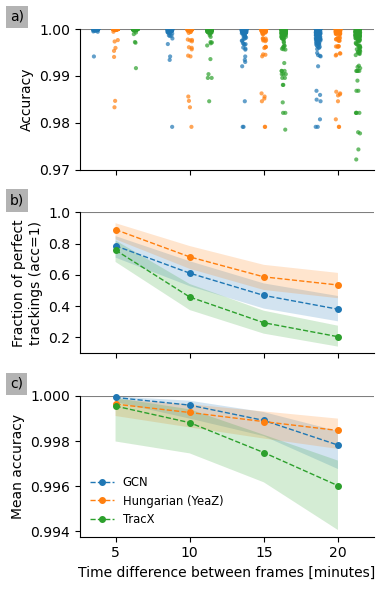

In [ ]:
fig, axs = plt.subplot_mosaic([['a)'], ['b)'], ['c)']], figsize=(
    4, 6), sharex=True, tight_layout=True)

axs['b)'].axhline(1.0, color='tab:gray')
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'gcn'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'gcn'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc.frac_perfect[res_agg.method == 'gcn'],
               'o--', markersize=4, linewidth=1,
               label='GCN', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'yeaz'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc.frac_perfect[res_agg.method == 'yeaz'],
               'o--', markersize=4, linewidth=1,
               label='Hungarian (YeaZ)', clip_on=False)
axs['b)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_lower[res_agg.method == 'tracx'], res_agg.acc.frac_perfect_ci_higher[res_agg.method == 'tracx'],
                       alpha=0.2)
axs['b)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc.frac_perfect[res_agg.method == 'tracx'],
               'o--', markersize=4, linewidth=1,
               label='TracX', clip_on=False)
# axs['b)'].set_xlabel('Time difference between frames [minutes]')
axs['b)'].set_ylabel('Fraction of perfect\ntrackings (acc=1)')
axs['b)'].spines.top.set_visible(False)
axs['b)'].spines.right.set_visible(False)
# axs['b)'].legend(fontsize='small', frameon=False)
axs['b)'].set_ylim((None, 1.0))

axs['c)'].axhline(1.0, color='tab:gray')
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean_ci_lower'][res_agg.method == 'gcn'], res_agg.acc['mean_ci_higher'][res_agg.method == 'gcn'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'gcn'], res_agg.acc['mean'][res_agg.method == 'gcn'],
               'o--', markersize=4, linewidth=1,
               label='GCN', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean_ci_lower'][res_agg.method == 'yeaz'], res_agg.acc['mean_ci_higher'][res_agg.method == 'yeaz'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'yeaz'], res_agg.acc['mean'][res_agg.method == 'yeaz'],
               'o--', markersize=4, linewidth=1,
               label='Hungarian (YeaZ)', clip_on=False)
axs['c)'].fill_between(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean_ci_lower'][res_agg.method == 'tracx'], res_agg.acc['mean_ci_higher'][res_agg.method == 'tracx'],
                       alpha=0.2)
axs['c)'].plot(res_agg.timediff[res_agg.method == 'tracx'], res_agg.acc['mean'][res_agg.method == 'tracx'],
               'o--', markersize=4, linewidth=1,
               label='TracX', clip_on=False)
axs['c)'].set_ylabel('Mean accuracy')
axs['c)'].spines.top.set_visible(False)
axs['c)'].spines.right.set_visible(False)
axs['c)'].legend(fontsize='small', frameon=False)
axs['c)'].set_ylim((None, 1.0))
axs['c)'].set_xlabel('Time difference between frames [minutes]')

sns.stripplot(
    data=res, x='timediff', y='acc', hue='method',
    dodge=True, s=3, alpha=0.7, ax=axs['a)'], legend=False, native_scale=True,
    # clip_on=False,
)
axs['a)'].axhline(1.0, color='tab:gray')
# some outliers from YeaZ and trackx are not shown !!
axs['a)'].set_ylim((0.97, 1))
axs['a)'].set_ylabel('Accuracy')
axs['a)'].set_xlabel('Time difference between frames [minutes]')
axs['a)'].set_xticks(res_agg.timediff.unique())
axs['a)'].spines.top.set_visible(False)
axs['a)'].spines.right.set_visible(False)

for label, ax in axs.items():
    # label physical distance in and down
    trans = mtransforms.ScaledTranslation(-0.7, 0.05, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='bottom',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# fig.savefig('../report_gnn/figures/timediff_accuracy.pdf')
plt.show()

### Evaluate p-value from bootstrapped samples


In [ ]:
from typing import Callable
from scipy.stats import ttest_ind


def bootstrap_sample(
        x: np.ndarray,
        n: int = 10_000,
        agg: Callable[[np.ndarray], float] = np.mean
) -> np.ndarray:
    """Compute confidence interval of a given data aggregate

    Parameters
    ----------
    x : np.ndarray
            data
    alpha : float, optional
            size of the confidence interval, by default 0.95
    n : int, optional
            number of resamples, by default 1_000
    agg : Callable[[np.ndarray], float], optional
            aggregation function, by default np.mean

    Returns
    -------
    aggs: np.ndarray of length ``n``
    """

    aggs = np.zeros(n)

    for i in range(n):
        # resample data uniformly
        sample = x[np.random.randint(0, len(x), len(x))]
        aggs[i] = agg(sample)

    return np.sort(aggs)

-- timediff = 5 --
t-test gcn <-> tracx : Ttest_indResult(statistic=9.621813281449622, pvalue=1.21280074388229e-19)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-33.36373288576967, pvalue=6.60580170221497e-112)
-- timediff = 10 --
t-test gcn <-> tracx : Ttest_indResult(statistic=35.485185741763274, pvalue=2.8517911747271694e-119)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-26.127361687270707, pvalue=5.807128988915839e-85)
-- timediff = 15 --
t-test gcn <-> tracx : Ttest_indResult(statistic=41.208030941714824, pvalue=5.971139412653793e-138)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-28.810491181131017, pvalue=2.8317544784460254e-95)
-- timediff = 20 --
t-test gcn <-> tracx : Ttest_indResult(statistic=43.04141885909937, pvalue=1.3862601521445968e-143)
t-test gcn <-> yeaz : Ttest_indResult(statistic=-37.02152643919866, pvalue=1.874189399149859e-124)


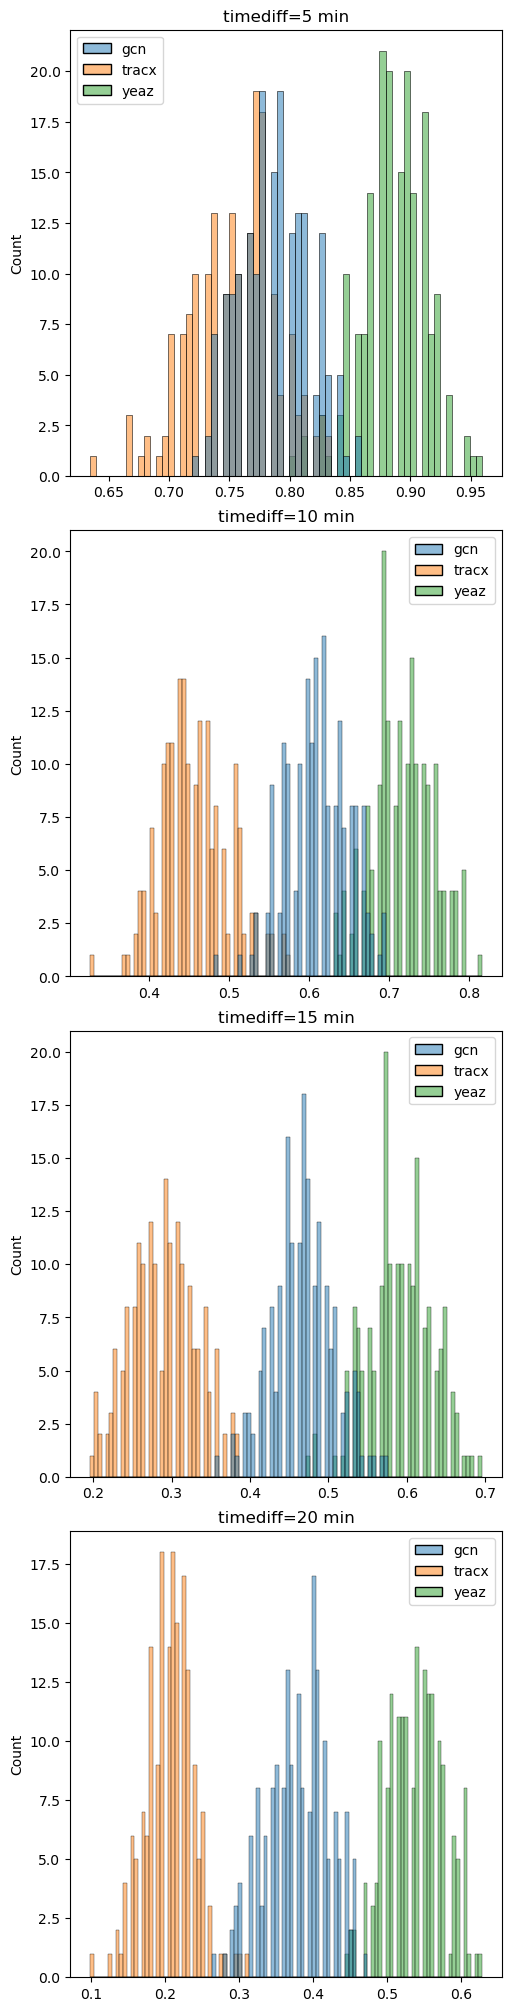

In [ ]:
fig, axs = plt.subplots(nrows=res.timediff.nunique(),
                        figsize=(5, 20), constrained_layout=True)

for ax, timediff in zip(axs, res.timediff.unique()):
    print(f'-- timediff = {timediff} --')

    # we resample ~180 times because that's the number of datapoints we have
    sample_gcn = bootstrap_sample(res.query(
        'timediff == @timediff and method == "gcn"').acc.to_numpy(), n=180, agg=frac_perfect)
    sample_tracx = bootstrap_sample(res.query(
        'timediff == @timediff and method == "tracx"').acc.to_numpy(), n=180, agg=frac_perfect)
    sample_yeaz = bootstrap_sample(res.query(
        'timediff == @timediff and method == "yeaz"').acc.to_numpy(), n=180, agg=frac_perfect)

    sns.histplot(dict(gcn=sample_gcn, tracx=sample_tracx,
                 yeaz=sample_yeaz), binwidth=0.005, ax=ax)
    ax.set_title(f'timediff={timediff} min')

    print(f't-test gcn <-> tracx : {ttest_ind(sample_gcn, sample_tracx)}')
    print(f't-test gcn <-> yeaz : {ttest_ind(sample_gcn, sample_yeaz)}')

## What induces mistakes ?


Index 31.0 out of range for fov FOV0 with 181 frames.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

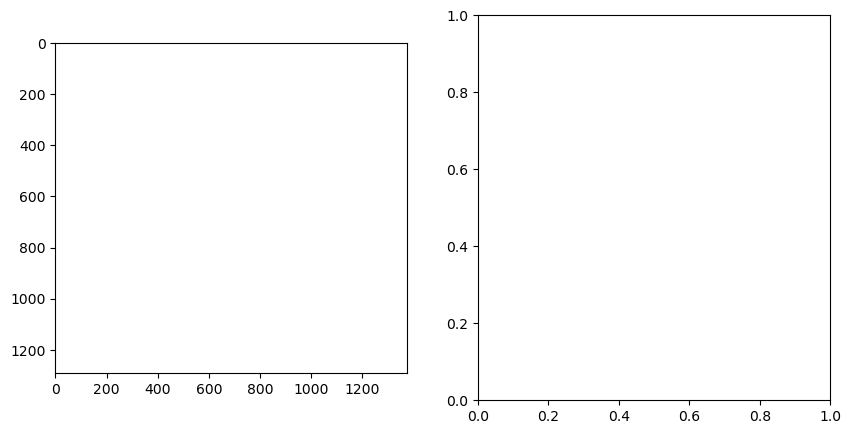

In [27]:
for _, row in res.query('(method == "gcn") and (fp > 0 or fn > 0)').sort_values('acc').iterrows():
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    vis.plot_visible(microscopy, row.t1, figax=(fig, axs[0]))
    vis.plot_segmentation(seg, row.t1, figax=(
        fig, axs[0]), cellids=True, alpha=0.2)
    vis.plot_visible(microscopy, row.t2, figax=(fig, axs[1]))
    vis.plot_segmentation(seg, row.t2, figax=(
        fig, axs[1]), cellids=True, alpha=0.2)
    fig.suptitle(f'{row.t1} -> {row.t2} (dt={row.timediff} mins)')
    ga = tracking.build_assgraph(tracking.build_cellgraph(
        feat, row.t1), tracking.build_cellgraph(feat, row.t2), include_target_feature=True)
    gat, *_ = tracking.to_data(ga)
    yhat = net.predict_assignment(gat)
    y = gat.y.cpu().numpy().reshape(yhat.shape)
    cellids1, cellids2 = seg.cell_ids(row.t1), seg.cell_ids(row.t2)
    coloriter = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for idx1, (idx2, idx2_hat) in enumerate(zip(np.argmax(y, axis=1), np.argmax(yhat, axis=1))):
        if idx2 != idx2_hat:
            color = next(coloriter)
            print(
                f'Expected {cellids1[idx1]}->{cellids2[idx2]}, got {cellids1[idx1]}->{cellids2[idx2_hat]}')
            vis._vis._plot_ellipse(feat._ellipse(cellids1[idx1], row.t1), figax=(
                fig, axs[0]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
            vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2], row.t2), figax=(
                fig, axs[1]), color=color, linewidth=2, alpha=0.8, draw_axes=False)
            vis._vis._plot_ellipse(feat._ellipse(cellids2[idx2_hat], row.t2), figax=(
                fig, axs[1]), color=color, linestyle='--', linewidth=2, alpha=0.8, draw_axes=False)
    plt.show()